# HACKATON

In [1]:
import pyModeS as pms
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap
import os
import geopandas as gpd
from sphericalpolygon import Sphericalpolygon
from astropy import units as u
from tqdm import tqdm

### FUNCTIONS

In [2]:
def isinside(zone,lat,lon):
        return (zone[0][0] <= lon <= zone[1][0]) and (zone[0][1] <= lat <= zone[1][1])

### READ DATA

In [130]:
route = './data/'
#AIRPORT DATA
runway = gpd.read_file(f'{route}runways.geojson')
threshold = gpd.read_file(f'{route}thresholds.geojson')

#SEPARATE COORDS
threshold['lat'] = threshold.apply(lambda row: row.geometry.y,axis=1)
threshold['lon'] = threshold.apply(lambda row: row.geometry.x,axis=1)
threshold['hdg'] = threshold.apply(lambda row: row.orientation,axis=1)

#VORTEX CATEGORY
vortex = pd.read_csv(f'{route}VORTEX.csv',sep=';')

#AIRPORT ZONE
barajas_zone = [[-4.058350,40.240497],[-3.242615,40.675054]]

In [185]:
#route = 'data/engage-hackathon-2025/year=2024/month=11/day=16/hour=12'
route = 'data/sample_scenario_00.parquet'
df = pd.read_parquet(route)

### PREPARE DATA FOR MODEL

Only aircraft that have bds = 08, eliminate via vortex category ('obstruction','rotorcraft','n/a') only aircraft.

In [186]:
#list containing id of aircraft
wake_flights_list = df[(df.bds=='08')&(df.wake_vortex.isin(vortex.id.tolist()))]['icao24'].value_counts().index.tolist()

#Filtered df with all ADS-B data msg
wake_df = df[df.icao24.isin(wake_flights_list)]

In [187]:
len(wake_df.groupby('icao24').count())

93

Find Airplanes on approach in adolfo suarez barajas airport, altitude below 2000ft during flight and inside airport zone

In [188]:
#Only aircraft that have flown below 2000ft
alt_flights_list = wake_df[wake_df.altitude<=6000]['icao24'].value_counts().index.tolist()
w_a_df = wake_df[wake_df.icao24.isin(alt_flights_list)]

In [189]:
#Only aircraft that have flown inside barajas airport zone
w_a_df['inside'] = w_a_df.apply(lambda row: isinside(barajas_zone,row['lat_deg'],row['lon_deg']) 
                                if pd.notna(row['lat_deg']) else False,axis=1)
inside_flights_list = w_a_df[w_a_df.inside == True]['icao24'].value_counts().index.tolist()
wai_df = w_a_df[w_a_df.icao24.isin(inside_flights_list)]

C:\Users\1570074\AppData\Local\Temp\ipykernel_1904\2076738098.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  w_a_df['inside'] = w_a_df.apply(lambda row: isinside(barajas_zone,row['lat_deg'],row['lon_deg'])


CHEK INTIAL ALTITUDE AND FINAL ALTITUDE INSIDE AIRPORT ZONE, IF POSITIVE LANDING, NEGATIVE TAKE OFF

In [190]:
#ONLY AIRCRAFT ON LANDING
tmp = wai_df[(wai_df.bds=='05')&(wai_df.inside==True)]
alt_min = tmp.loc[tmp.groupby('icao24')['ts'].idxmin(), ['icao24', 'altitude']].rename(columns={'altitude': 'alt_min'})
alt_max = tmp.loc[tmp.groupby('icao24')['ts'].idxmax(), ['icao24', 'altitude']].rename(columns={'altitude': 'alt_max'})
dif_df = alt_min.merge(alt_max, on='icao24')
dif_df['dif'] = dif_df.alt_min-dif_df.alt_max
landing_flights_list = dif_df[dif_df['dif']>0]['icao24'].value_counts().index.tolist()
landing_df = wai_df[wai_df.icao24.isin(landing_flights_list)]
landing_df['datetime'] = pd.to_datetime(landing_df["ts"], unit="ms")

C:\Users\1570074\AppData\Local\Temp\ipykernel_1904\3065336681.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  landing_df['datetime'] = pd.to_datetime(landing_df["ts"], unit="ms")


In [191]:
landing_df.bds.value_counts()

bds
05    149
09    139
62     62
65     32
61     17
08     16
Name: count, dtype: Int64

In [195]:
tmp = landing_df[(landing_df.inside==True)]
tmp

,df,squawk,bds60_bds,bds60_heading,bds60_IAS,bds60_Mach,bds60_vrate_barometric,bds60_vrate_inertial,icao24,ts,...,bds30_bds,bds30_issued_ra,bds30_terminated,bds30_multiple,year,month,day,hour,inside,datetime
474825,17,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,346291,1737545298635,...,<NA>,<NA>,<NA>,<NA>,2025,1,22,11,True,2025-01-22 11:28:18.635
475723,17,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,346291,1737545328443,...,<NA>,<NA>,<NA>,<NA>,2025,1,22,11,True,2025-01-22 11:28:48.443
475855,17,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,346291,1737545332533,...,<NA>,<NA>,<NA>,<NA>,2025,1,22,11,True,2025-01-22 11:28:52.533
476219,17,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,346291,1737545344185,...,<NA>,<NA>,<NA>,<NA>,2025,1,22,11,True,2025-01-22 11:29:04.185
476413,17,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,346291,1737545349612,...,<NA>,<NA>,<NA>,<NA>,2025,1,22,11,True,2025-01-22 11:29:09.612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678366,17,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,346291,1737545352177,...,<NA>,<NA>,<NA>,<NA>,2025,1,22,11,True,2025-01-22 11:29:12.177
678809,17,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,346291,1737545359429,...,<NA>,<NA>,<NA>,<NA>,2025,1,22,11,True,2025-01-22 11:29:19.429
678917,17,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,346291,1737545362292,...,<NA>,<NA>,<NA>,<NA>,2025,1,22,11,True,2025-01-22 11:29:22.292
679139,17,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,346291,1737545369460,...,<NA>,<NA>,<NA>,<NA>,2025,1,22,11,True,2025-01-22 11:29:29.460


<Axes: >

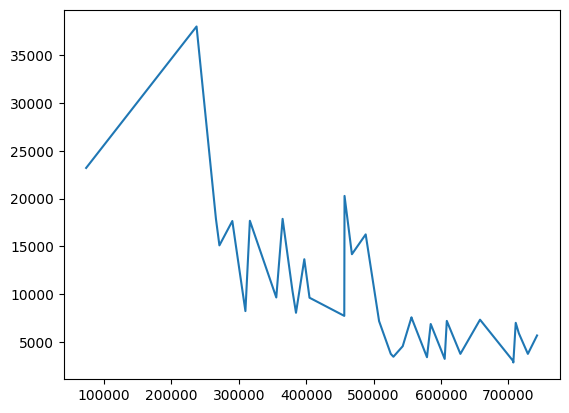

In [139]:
landing_df[(landing_df.icao24=='3480c3')&(pd.notna(landing_df.bds05_altitude))].bds05_altitude.plot()

In [140]:

landing_df['datetime'] = pd.to_datetime(landing_df["ts"], unit="ms")


C:\Users\1570074\AppData\Local\Temp\ipykernel_1904\4217230171.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  landing_df['datetime'] = pd.to_datetime(landing_df["ts"], unit="ms")


In [141]:
landing_df.

SyntaxError: invalid syntax (4137020247.py, line 1)

In [ ]:
landing_df['source'].value_counts()

In [ ]:
landing_df[(landing_df.icao24=='3480c3')&(landing_df.bds=='05')&(landing_df.inside==True)].altitude.plot()

In [ ]:
landing_df.icao24.value_counts()

In [142]:
landing_df.groupby('icao24').count()

,df,tisb,bds,tc,NUCp,groundspeed,track,parity,lat_cpr,lon_cpr,...,alt_hold,approach_mode,lnav_mode,bds21_bds,bds21_registration,bds17_bds43,bds17_bds55,bds17_bds56,inside,datetime
icao24,,,,,,,,,,,,,,,,,,,,,
010236,3472,0,2193,1188,1188,1185,1185,1188,1188,1188,...,0,0,0,0,0,0,0,0,3472,3472
01024c,5179,0,3518,1786,1786,1813,1813,1786,1786,1786,...,0,0,0,0,0,0,0,0,5179,5179
06a2b3,2286,0,1579,821,821,857,857,821,821,821,...,0,0,0,0,0,0,0,0,2286,2286
344446,3934,0,2611,1224,1224,1187,1187,1224,1224,1224,...,0,0,0,0,0,0,0,0,3934,3934
3444c3,2754,0,1859,884,884,903,903,884,884,884,...,0,0,0,0,0,0,0,0,2754,2754
3451da,4845,0,3384,1627,1627,1632,1632,1627,1627,1627,...,0,0,0,1,1,0,0,0,4845,4845
3452c8,2402,0,1745,634,634,625,625,634,634,634,...,0,0,0,0,0,0,0,0,2402,2402
345353,1914,0,1345,657,657,648,648,657,657,657,...,114,114,114,0,0,0,0,0,1914,1914
34538e,7547,0,4538,1775,1775,1747,1747,1775,1775,1775,...,0,0,0,0,0,0,0,0,7547,7547


In [143]:
for i in df.columns:
    print(i)

df
tisb
icao24
bds
tc
NUCp
groundspeed
track
parity
lat_cpr
lon_cpr
ts
lat_deg
lon_deg
NICb
altitude
source
bds20_bds
bds20_callsign
bds05_tc
bds05_NUCp
bds05_NICb
bds05_altitude
bds05_source
bds05_parity
bds05_lat_cpr
bds05_lon_cpr
bds40_bds
bds40_selected_mcp
bds40_barometric_setting
squawk
bds60_bds
bds60_heading
bds60_IAS
bds60_Mach
bds60_vrate_barometric
bds60_vrate_inertial
NACv
vrate_src
vertical_rate
geo_minus_baro
selected_altitude
barometric_setting
NACp
tcas_operational
bds17_bds
bds17_bds05
bds17_bds06
bds17_bds20
bds17_bds41
bds17_bds42
bds17_bds44
bds17_bds45
bds17_bds48
bds17_bds54
bds17_bds5f
bds17_bds60
bds40_selected_fms
version
NICa
GVA
SIL
BAI
HRD
SILs
TAH
id
wake_vortex
callsign
selected_heading
bds45_bds
bds45_turbulence
bds45_wind_shear
bds45_microburst
bds45_icing
bds45_wake_vortex
bds45_static_temperature
bds45_static_pressure
bds45_radio_height
bds40_target_source
subtype
emergency_state
bds50_bds
bds50_roll
bds50_track
bds50_groundspeed
bds50_track_rate
bds50

In [144]:
df.lon_deg.value_counts()

lon_deg
-3.604436    787
-3.604431    714
-3.574677    324
-3.574630    324
-3.574707    313
            ... 
-2.627258      1
-0.893342      1
-2.213995      1
-7.190052      1
-6.558713      1
Name: count, Length: 151286, dtype: int64

In [145]:
f_df.lon_deg.value_counts()

NameError: name 'f_df' is not defined

In [146]:
threshold

,runway,orientation,geometry,lat,lon,hdg
0,18R/36L,18R,POINT (-3.57484 40.53022),40.530219,-3.574838,18R
1,14R/32L,32L,POINT (-3.54719 40.45648),40.456478,-3.547192,32L
2,14L/32R,32R,POINT (-3.53258 40.47001),40.470008,-3.532581,32R
3,18L/36R,18L,POINT (-3.55938 40.53262),40.532622,-3.559381,18L


290it [00:00, 353.59it/s] 


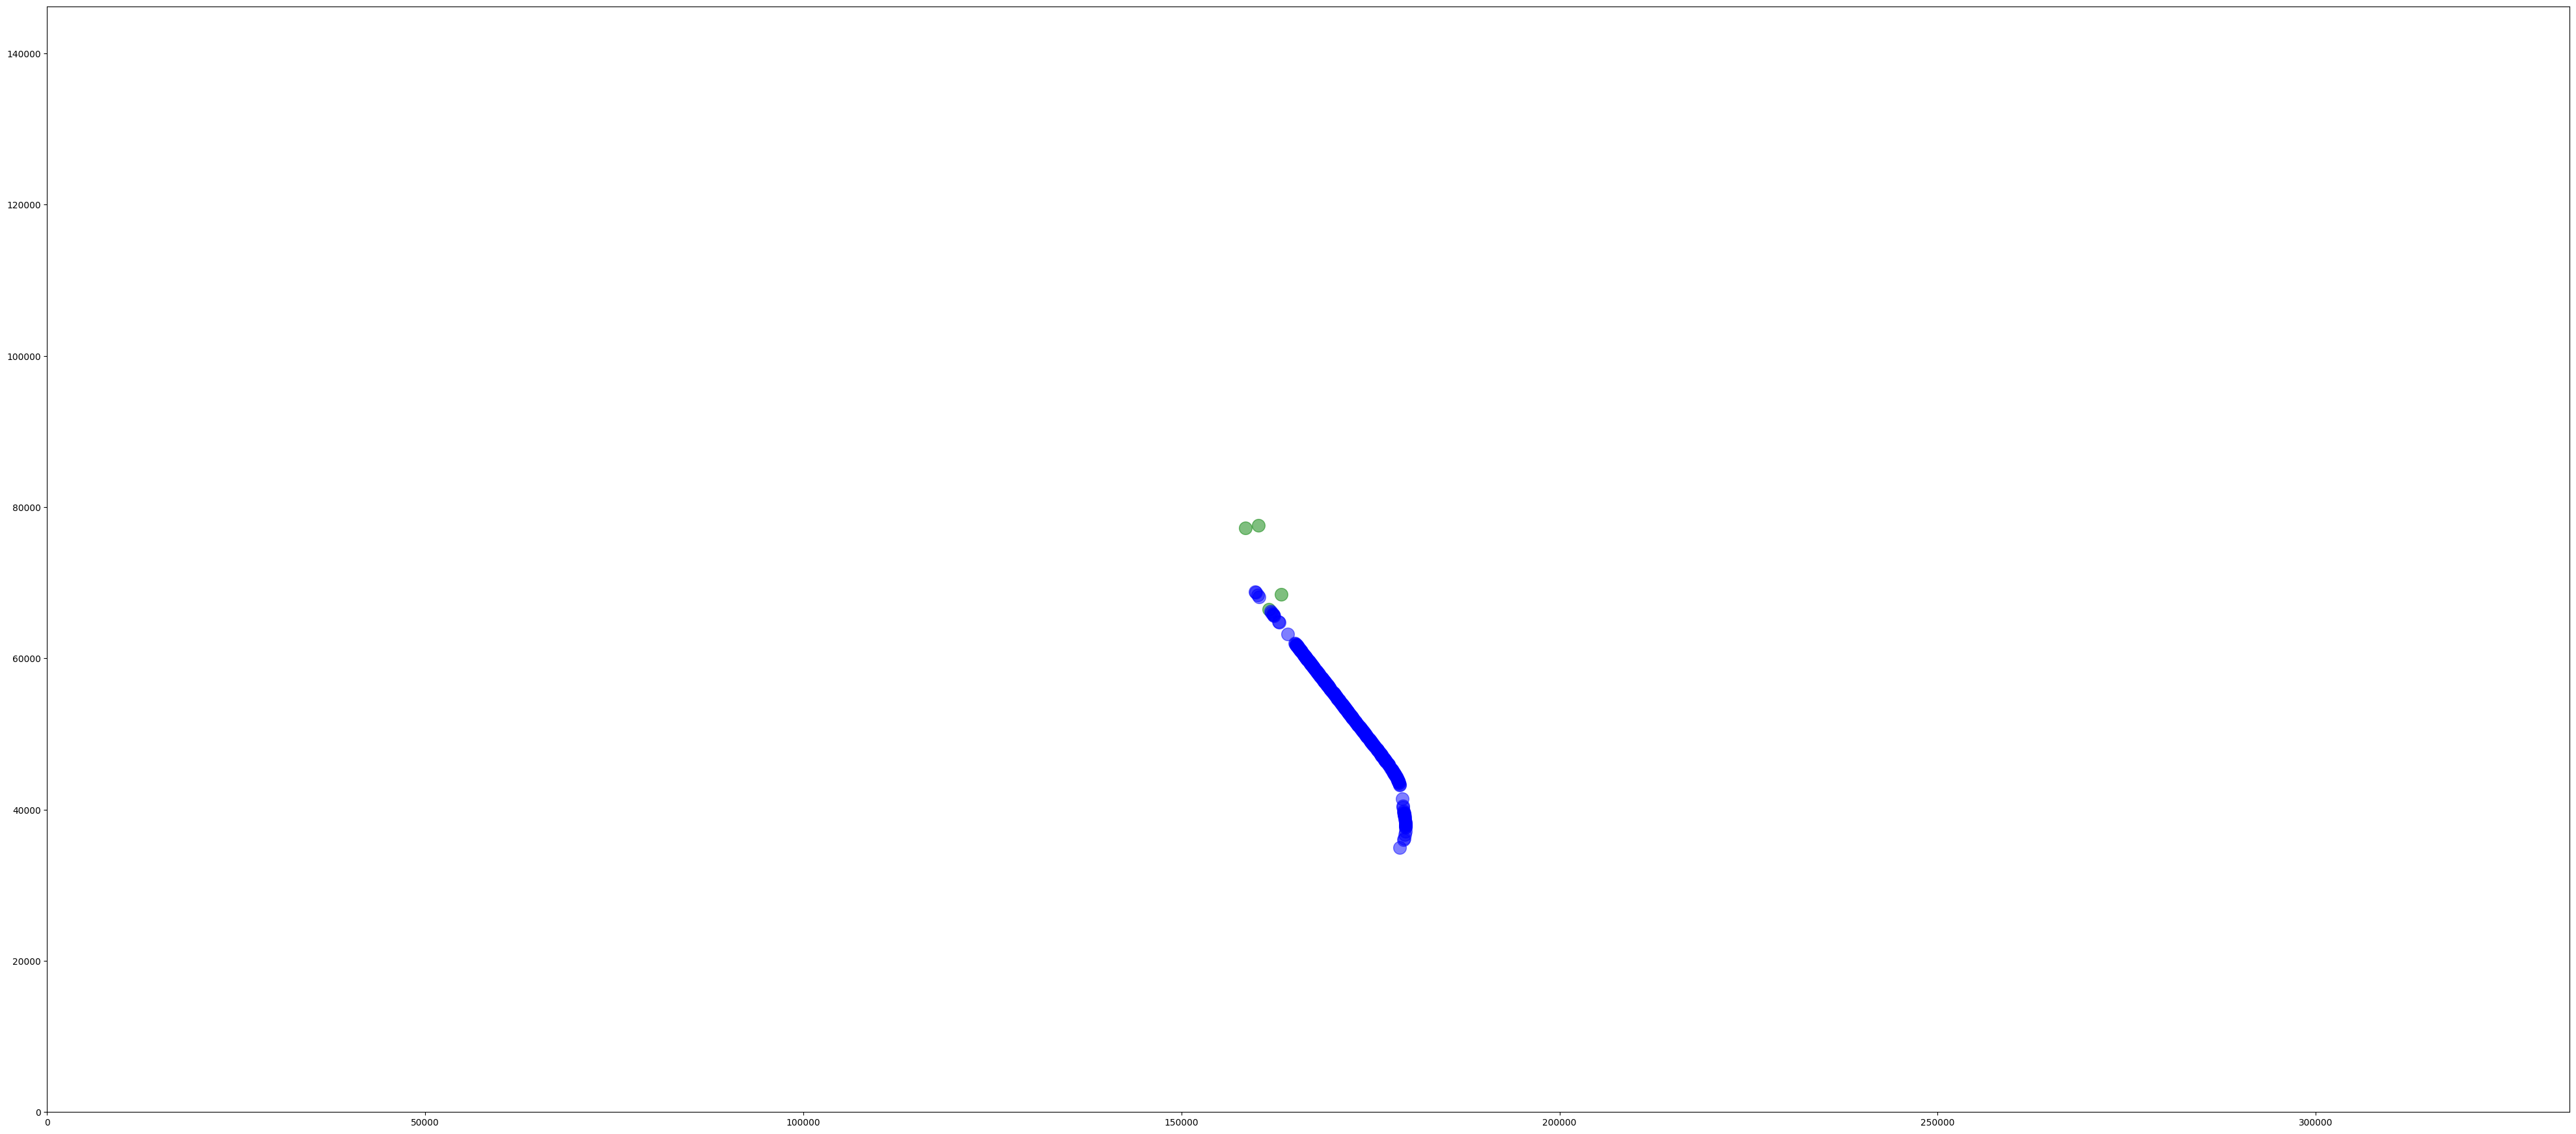

In [151]:
my_map = Basemap(projection='merc',llcrnrlon=-5, llcrnrlat=40,urcrnrlon=-2, urcrnrlat=41,resolution='i', area_thresh=10000,suppress_ticks=False)
#my_map = Basemap(projection='merc',llcrnrlon=-25, llcrnrlat=24,urcrnrlon=55, urcrnrlat=65,resolution='i', area_thresh=10000,suppress_ticks=False)
my_map.drawcoastlines(linewidth=1)
my_map.drawcountries(linewidth=0.5, color='black')

zone_lat = [37,37,44,44,37]
zone_lon = [-9,1,1,-9,-9]

[[-3.773804,40.351118],[-3.314438,40.620516]]

wpt_x, wpt_y = my_map(zone_lon, zone_lat)
plt.plot(wpt_x, wpt_y, color='green', alpha=0.3, linewidth=2)

tmp = tmp

for _,row in threshold.iterrows():
    wpt_x, wpt_y = my_map(row.lon, row.lat)
    plt.scatter(wpt_x, wpt_y, color='green', alpha=0.5, s=200)

for _,row in tqdm(tmp.iterrows()):
    wpt_x, wpt_y = my_map(row.lon_deg, row.lat_deg)
    plt.scatter(wpt_x, wpt_y, color='blue', alpha=0.5, s=200)
    
# Ajustar el tamaño del gráfico
plt.gcf().set_figheight(30)
plt.gcf().set_figwidth(50)

# Mostrar el gráfico
#plt.savefig('outputs/sectors.png', bbox_inches='tight')
plt.show()

In [167]:
landing_df[(landing_df.icao24=='347307')&(landing_df.bds=='05')&(landing_df.inside==True)]

,df,tisb,icao24,bds,tc,NUCp,groundspeed,track,parity,lat_cpr,...,alt_hold,approach_mode,lnav_mode,bds21_bds,bds21_registration,bds17_bds43,bds17_bds55,bds17_bds56,inside,datetime
760691,17,None,347307,05,11.0,7.0,NaN,NaN,even,92818.0,...,None,None,None,None,None,None,None,None,True,2024-11-16 12:31:02.214
761374,17,None,347307,05,11.0,7.0,NaN,NaN,odd,78529.0,...,None,None,None,None,None,None,None,None,True,2024-11-16 12:31:16.939
762858,17,None,347307,05,11.0,7.0,NaN,NaN,odd,79401.0,...,None,None,None,None,None,None,None,None,True,2024-11-16 12:31:56.682
763953,17,None,347307,05,11.0,7.0,NaN,NaN,even,94460.0,...,None,None,None,None,None,None,None,None,True,2024-11-16 12:32:18.884
764042,17,None,347307,05,11.0,7.0,NaN,NaN,odd,79802.0,...,None,None,None,None,None,None,None,None,True,2024-11-16 12:32:20.243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994239,17,None,347307,05,11.0,7.0,NaN,NaN,odd,80879.0,...,None,None,None,None,None,None,None,None,True,2024-11-16 12:33:28.275
994685,17,None,347307,05,11.0,7.0,NaN,NaN,even,95707.0,...,None,None,None,None,None,None,None,None,True,2024-11-16 12:33:36.479
995711,17,None,347307,05,11.0,7.0,NaN,NaN,even,96046.0,...,None,None,None,None,None,None,None,None,True,2024-11-16 12:33:59.377
996037,17,None,347307,05,11.0,7.0,NaN,NaN,even,96149.0,...,None,None,None,None,None,None,None,None,True,2024-11-16 12:34:06.761


In [164]:
tmp.track.value_counts().head(50)

track
127.418166    47
127.360759    46
83.031743     38
127.252228    36
180.000000    34
127.534809    33
321.826862    25
127.874984    25
127.226108    24
127.653955    24
132.461455    24
179.775312    24
132.423428    22
132.410498    22
127.610395    22
127.739649    21
261.562500    20
132.697892    20
82.848964     20
83.418055     19
127.278174    19
83.174674     18
83.095457     18
83.263989     18
132.560302    18
132.340250    18
127.963306    17
127.450578    16
132.002211    16
127.585370    16
83.433701     15
83.206169     15
83.057205     15
322.431408    14
83.148470     14
127.619364    14
127.366669    14
132.436230    14
132.137595    13
140.625000    13
83.157227     13
143.437500    13
82.902424     13
127.959283    13
132.650721    12
132.314019    12
132.535627    12
83.237610     12
127.476180    12
82.822754     12
Name: count, dtype: int64

In [150]:
tmp.iloc[-1].dropna()

df                                  17
icao24                          347307
bds                                 05
tc                                11.0
NUCp                               7.0
parity                             odd
lat_cpr                        81732.0
lon_cpr                        74920.0
ts                       1731760469903
lat_deg                      40.414977
lon_deg                      -3.505138
NICb                               0.0
altitude                        2925.0
source                      barometric
inside                            True
datetime    2024-11-16 12:34:29.903000
Name: 997057, dtype: object

In [180]:
landing_df[(landing_df.icao24=='347307')&(landing_df.bds=='09')].vertical_rate.tail(60)

967629      64.0
967808     -64.0
967874     -64.0
968059       0.0
968495    -128.0
968775     -64.0
968881    -320.0
969316    -960.0
969393    -896.0
969779   -1152.0
970292   -1088.0
970458   -1088.0
970556   -1152.0
970657   -1152.0
970684   -1152.0
971049    -576.0
971162    -640.0
971369    -512.0
971441    -640.0
972173    -832.0
975897     -64.0
975924    -128.0
976054     -64.0
986142    -384.0
986484    -448.0
986954   -1728.0
987875    -768.0
987882    -768.0
988672    -128.0
989075    -128.0
989392       0.0
989423       0.0
990516    -128.0
991174       0.0
991923       0.0
992038      64.0
992117      64.0
992205    -128.0
992710     -64.0
992868       0.0
993002     -64.0
993119      64.0
993197       0.0
993513       0.0
993656     256.0
993873     128.0
994062     -64.0
994220       0.0
994252     -64.0
994688    -768.0
995120    -896.0
995194    -896.0
995457   -1152.0
995587   -1088.0
995749   -1152.0
995946   -1152.0
996160   -1024.0
996283   -1024.0
997288    -832

In [184]:
landing_df[(landing_df.icao24=='347307')&(landing_df.bds=='65')]

,df,tisb,icao24,bds,tc,NUCp,groundspeed,track,parity,lat_cpr,...,alt_hold,approach_mode,lnav_mode,bds21_bds,bds21_registration,bds17_bds43,bds17_bds55,bds17_bds56,inside,datetime
555,17,None,347307,65,NaN,NaN,NaN,NaN,None,NaN,...,None,None,None,None,None,None,None,None,False,2024-11-16 12:00:15.113
6397,17,None,347307,65,NaN,NaN,NaN,NaN,None,NaN,...,None,None,None,None,None,None,None,None,False,2024-11-16 12:02:32.358
7227,17,None,347307,65,NaN,NaN,NaN,NaN,None,NaN,...,None,None,None,None,None,None,None,None,False,2024-11-16 12:02:52.599
7571,17,None,347307,65,NaN,NaN,NaN,NaN,None,NaN,...,None,None,None,None,None,None,None,None,False,2024-11-16 12:03:00.105
8578,17,None,347307,65,NaN,NaN,NaN,NaN,None,NaN,...,None,None,None,None,None,None,None,None,False,2024-11-16 12:03:17.691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985519,17,None,347307,65,NaN,NaN,NaN,NaN,None,NaN,...,None,None,None,None,None,None,None,None,False,2024-11-16 12:30:00.352
991428,17,None,347307,65,NaN,NaN,NaN,NaN,None,NaN,...,None,None,None,None,None,None,None,None,False,2024-11-16 12:32:19.597
993286,17,None,347307,65,NaN,NaN,NaN,NaN,None,NaN,...,None,None,None,None,None,None,None,None,False,2024-11-16 12:33:07.227
996710,17,None,347307,65,NaN,NaN,NaN,NaN,None,NaN,...,None,None,None,None,None,None,None,None,False,2024-11-16 12:34:22.620
